In [ ]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 23.2 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Training Machine Learning Models

When setting out to train ML models, you should go through the following stages:

1. Defining the learning problem
  * What problem are you trying to solve?
  * Supervised learning (labels)? Unsupervised learning (looking for patterns without labels)? Reinforcement learning (dynamical system)?
  * What data will you need to solve your problem?

2. Obtaining/Gathering Data
  * Your answers to the questions in 1. will inform your actions in this section.
  * We won't cover this in this course, but this is a major part of applied machine learning.

3. Exploratory Data Analysis
  * Number of samples (rows) and variables (columns)
  * Data types (real-valued, count/ordinal, categorical, text etc.)
  * Missing values
  * Distributions of variables & Outliers
  * Statsitical relationships between variables (covariance, correlation, mutual information)

4. Model Selection & Training
  * Split your data into a train set and a test set (and DON"T touch the test set until you are ready to evaluate your final model)
  * Data pre-processing (e.g. feature scaling, removing outliers etc.)
  * Decide which models to try based on the problem and your analysis of the data
  * Decide which metrics you will use to evaluate the performance of the fitted models
  * Experiment with several combinations of hyper-parameters using cross-validation over your train set (you should have a set of evauation metrics for every combination of hyper-parameters)
  * Carefully asses the metrics for each model + set of hyper-parameters (looking for overfitting etc.) and select the best performing model

5. Model evaluation
 * Train the best model (+ best set hyper-parameters) on the full train set
 * Evaluate the model *ONCE* on the test set - this is the *FINAL* evaluation of your model.      

## 1. Defining the learning problem

To illustrate the process outlined above I am going to train classification models on the `Iris` dataset.

## 2. Obtaining the data

Load the data from the plotly library.

In [ ]:
# Load data into a pandas dataframe and show the first 5 samples
df = px.data.iris()
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_id
0,5.1,3.5,1.4,0.2,setosa,1
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,1
3,4.6,3.1,1.5,0.2,setosa,1
4,5.0,3.6,1.4,0.2,setosa,1


## 3. Exploratory Data Analysis

In [ ]:
# Num samples, num variables, data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
 5   species_id    150 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [ ]:
# Summary Statistics
df.describe()

,sepal_length,sepal_width,petal_length,petal_width,species_id
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,2.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,1.000000
25%,5.100000,2.800000,1.600000,0.300000,1.000000
50%,5.800000,3.000000,4.350000,1.300000,2.000000
75%,6.400000,3.300000,5.100000,1.800000,3.000000
max,7.900000,4.400000,6.900000,2.500000,3.000000


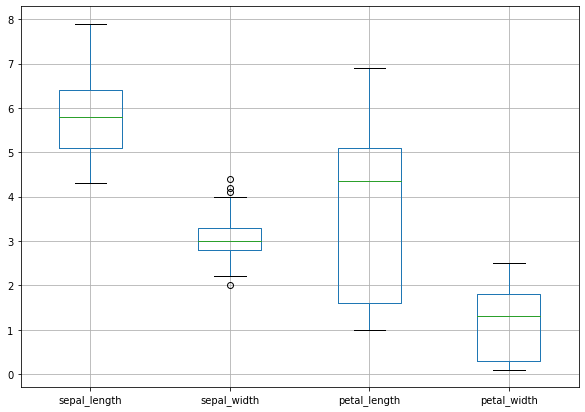

In [ ]:
# Box plots
df.iloc[:,:-2].boxplot(figsize=(10,7))
plt.show()

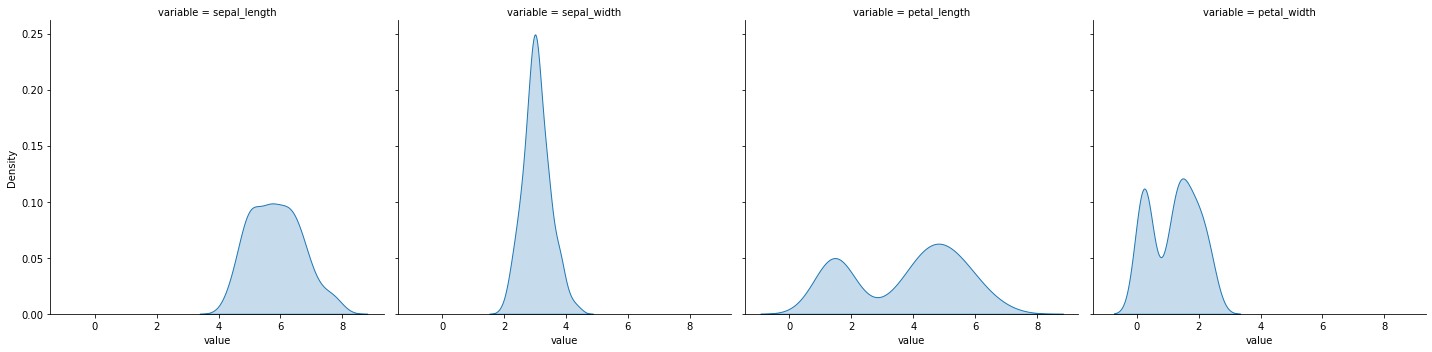

In [ ]:
# Distributions
sns.displot(
    data=df.iloc[:,:-2].melt(),
    x='value',
    kind='kde',
    fill=True,
    col='variable'
)
plt.show()

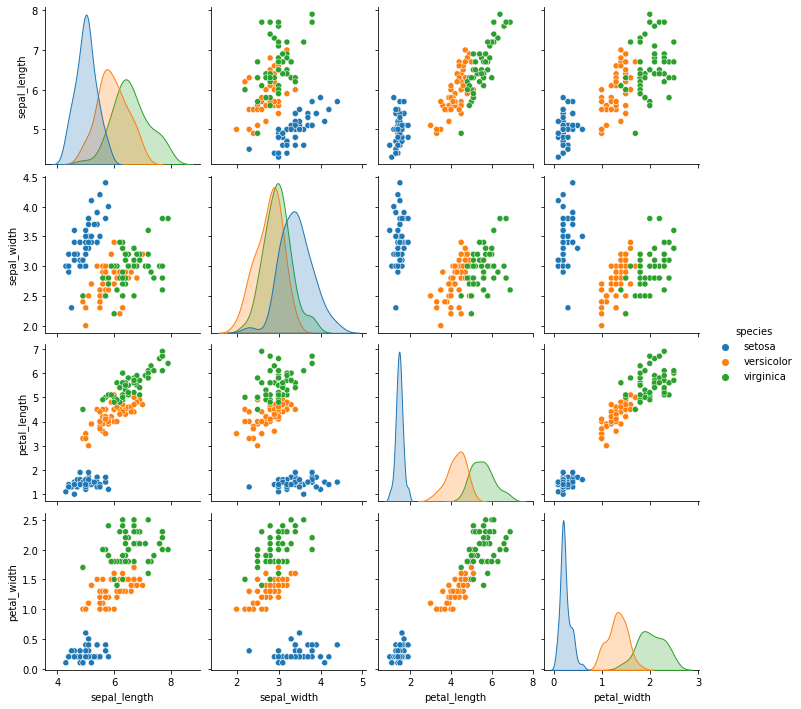

In [ ]:
# Relationships between variables
sns.pairplot(df.iloc[:,:-1], hue='species')
plt.show()

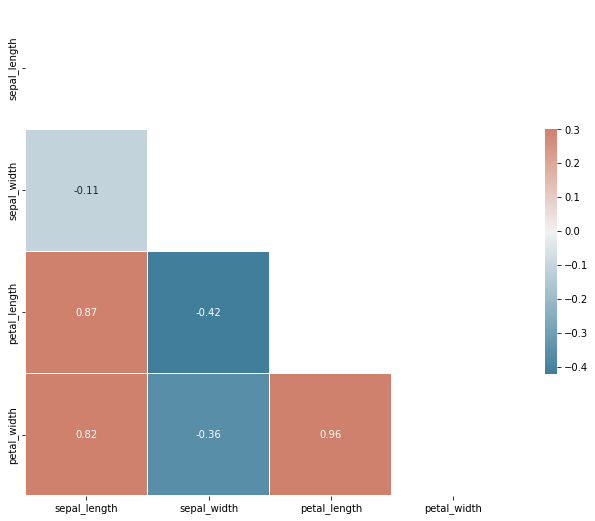

In [ ]:
# Compute the correlation matrix
corr = df.iloc[:,:-2].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# 3d visualisation
symbols = ['square','circle', 'diamond']
fig = px.scatter_3d(
    df, x='sepal_length', y='sepal_width', z='petal_width',
    color='petal_length', size='petal_length', symbol='species',
    symbol_sequence=symbols, size_max=25, opacity=0.5
)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

## 4. Model Selection & Training

In [ ]:
# Splitting feature data from label data
X, y = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']], df[['species']]
print("Original shapes: ", "X:", X.shape, " y:", y.shape)

Original shapes:  X: (150, 4)  y: (150, 1)


In [ ]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shapes after splitting:\n\nX_train: {X_train.shape}, y_train: {y_train.shape}\
      \nX_test: {X_test.shape}, y_test: {y_test.shape}")

Shapes after splitting:

X_train: (120, 4), y_train: (120, 1)      
X_test: (30, 4), y_test: (30, 1)


In [ ]:
# Make a pipeline: Scaling --> Support Vector Classifier
pipeline = make_pipeline(StandardScaler(), SVC())
pipeline.steps

[('standardscaler', StandardScaler()), ('svc', SVC())]

### Finding the optimal model: parameters vs hyper-parameters

* We need to optimise two things (i) model parameters (e.g. the weights in linear regression), and (ii) model hyper-parameters (e.g. the learning rate in gradient descent)
* Note: it is **very** important to treat your test set as data that you DO NOT HAVE ACCESS TO unti such a time as you are ready to make a final evaluation on your trained model(s) - this means that it will give you an indication of how your model will perform on new, unseen data in the future.
* But without the test set, how are we able to test different hyper-parameter values on unseen data?

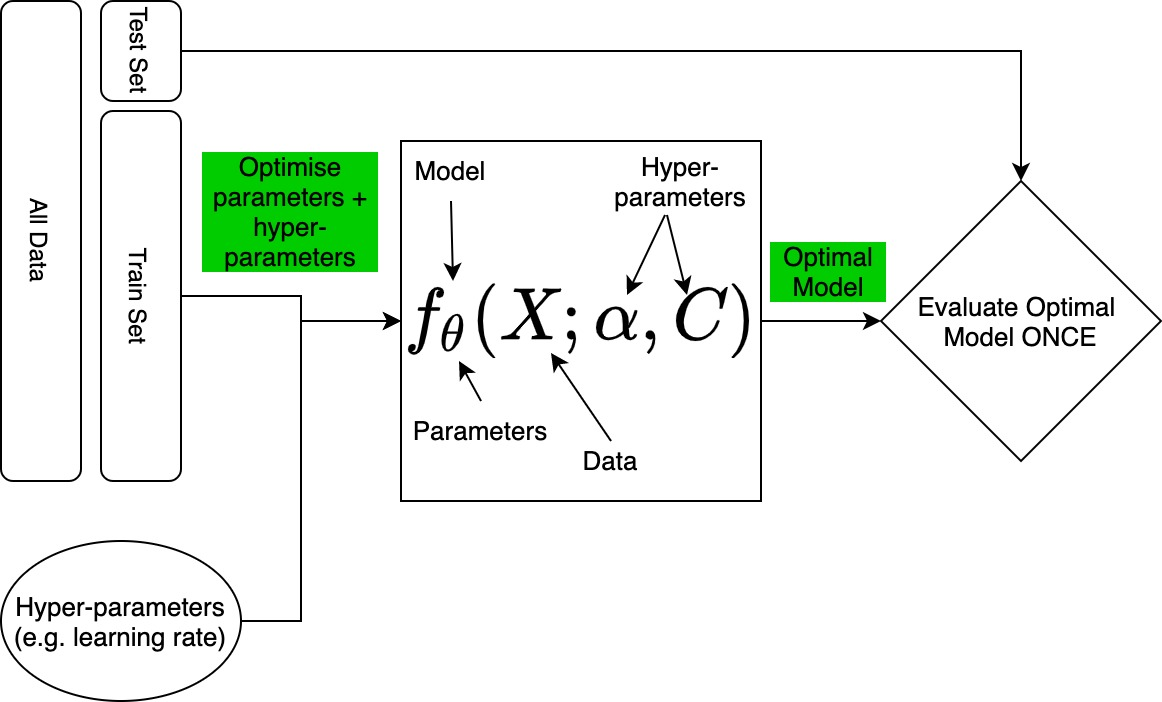

## Cross-Validation for hyper-parameter tuning

"When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

A model is trained using  of the folds as training data;

the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small." - [Source](https://scikit-learn.org/stable/modules/cross_validation.html)

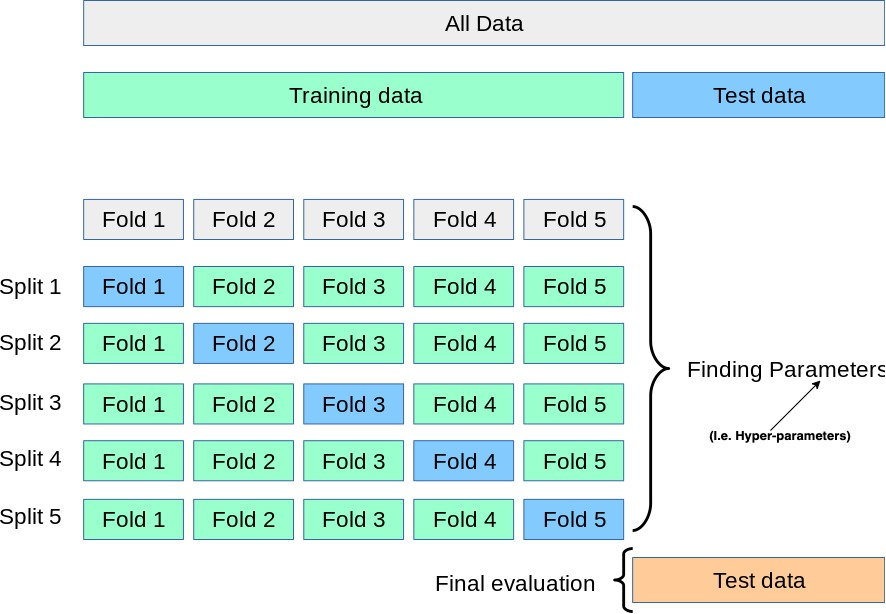

In [ ]:
# Hyper-parameter tuning on VALIDATION SETS using 4-fold Cross Validation
# Set the parameters by cross-validation

hyper_parameter_grids = [
    { # Grid 1: linear kernel
      "svc__kernel": ["linear"],
      "svc__C": [1, 10, 100, 1000]
    },
    { # Grid 2: polynomial kernel
      "svc__kernel": ["poly"],
      "svc__degree": [2,3,4,5],
    },
    { # Grid 2: RBF kernel
      "svc__kernel": ["rbf"],
      "svc__gamma": [1e-3, 1e-4],
      "svc__C": [1, 10, 100, 1000],
    },
]

# Evaluation metrics
scores = ["accuracy", "precision_micro", "recall_micro"]

for score in scores:
    print("*"*100)
    print("# Tuning hyper-parameters for %s" % score)
    print("*"*100)
    print()

    # This performs gridsearch, evaluating each set of hyper-parameters using k-fold
    # cross validation.
    clf = GridSearchCV(pipeline, hyper_parameter_grids, scoring=score, cv=4, n_jobs=4)


    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

****************************************************************************************************
# Tuning hyper-parameters for accuracy
****************************************************************************************************



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Best parameters set found on development set:

{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

Grid scores on development set:

0.958 (+/-0.055) for {'svc__C': 1, 'svc__kernel': 'linear'}
0.958 (+/-0.055) for {'svc__C': 10, 'svc__kernel': 'linear'}
0.950 (+/-0.075) for {'svc__C': 100, 'svc__kernel': 'linear'}
0.950 (+/-0.075) for {'svc__C': 1000, 'svc__kernel': 'linear'}
0.825 (+/-0.099) for {'svc__degree': 2, 'svc__kernel': 'poly'}
0.925 (+/-0.055) for {'svc__degree': 3, 'svc__kernel': 'poly'}
0.783 (+/-0.033) for {'svc__degree': 4, 'svc__kernel': 'poly'}
0.850 (+/-0.111) for {'svc__degree': 5, 'svc__kernel': 'poly'}
0.458 (+/-0.433) for {'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.458 (+/-0.433) for {'svc__C': 1, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
0.867 (+/-0.125) for {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.458 (+/-0.433) for {'svc__C': 10, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
0.967 (+/-0.047) for {'svc__C': 100, 'svc__gam

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Best parameters set found on development set:

{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

Grid scores on development set:

0.958 (+/-0.055) for {'svc__C': 1, 'svc__kernel': 'linear'}
0.958 (+/-0.055) for {'svc__C': 10, 'svc__kernel': 'linear'}
0.950 (+/-0.075) for {'svc__C': 100, 'svc__kernel': 'linear'}
0.950 (+/-0.075) for {'svc__C': 1000, 'svc__kernel': 'linear'}
0.825 (+/-0.099) for {'svc__degree': 2, 'svc__kernel': 'poly'}
0.925 (+/-0.055) for {'svc__degree': 3, 'svc__kernel': 'poly'}
0.783 (+/-0.033) for {'svc__degree': 4, 'svc__kernel': 'poly'}
0.850 (+/-0.111) for {'svc__degree': 5, 'svc__kernel': 'poly'}
0.458 (+/-0.433) for {'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.458 (+/-0.433) for {'svc__C': 1, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
0.867 (+/-0.125) for {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.458 (+/-0.433) for {'svc__C': 10, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
0.967 (+/-0.047) for {'svc__C': 100, 'svc__gam

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



## 5. Model Evaluation


In [ ]:
#Fit the *Best* model to the train set
pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=100, gamma=1e-3)
)
pipeline.fit(X_train, y_train['species'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100, gamma=0.001))])

Evaluation Metrics on Train Set:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        40
  versicolor       0.97      0.93      0.95        41
   virginica       0.93      0.97      0.95        39

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



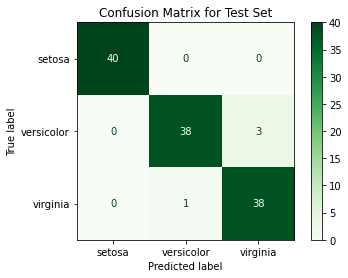

In [ ]:
# Evaluating classifier on train set
y_train_pred = pipeline.predict(X_train)
print("Evaluation Metrics on Train Set:\n")
print(classification_report(y_train, y_train_pred))

# confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    pipeline,
    X_train,
    y_train,
    display_labels=['setosa', 'versicolor', 'virginia'],
    cmap='Greens'
)
disp.ax_.set_title("Confusion Matrix for Test Set")
plt.show()

Evaluation Metrics on Test Set:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



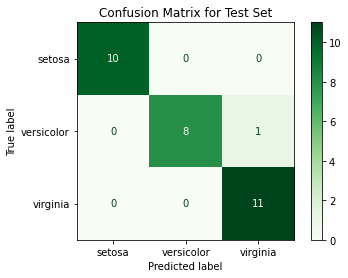

In [ ]:
# Evaluating classifier on test set
y_test_pred = pipeline.predict(X_test)
print("Evaluation Metrics on Test Set:\n")
print(classification_report(y_test, y_test_pred))

# confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    pipeline,
    X_test,
    y_test,
    display_labels=['setosa', 'versicolor', 'virginia'],
    cmap='Greens'
)
disp.ax_.set_title("Confusion Matrix for Test Set")
plt.show()